## Machine Learning: Predicting Car Prizes using K-Nearest-Neighbors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
%matplotlib inline

names = ["symboling", "normalized_losses", "make", "fuel_type", "aspiration", "num_doors", "body_style",
        "drive_wheels", "engine_location", "wheel_base", "length", "width", "height", "curb_weight", "engine_type",
        "num_cylinders", "engine_size", "fuel_system", "bore", "stroke", "compression_ratio", "horsepower", "peak_rpm",
         "city_mpg", "highway_mpg", "price"]

cars = pd.read_csv("imports-85.data", names = names)
cars.head(5)

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


<b>We want to predict the "price" column using a k-nearest-neigbors-algorithm. some columns that can be used to accomplish this (note: those columns must be numeric and have to be scaled ordinally in order for our euclidean norm to be applicable) include: 
- length, width, height, weight (as bigger cars will generally be more expensive)
- num_cylinders (wich beforhand would have to be converted to numerics)
- horsepower, peak_rpm (higher values will probably correlate with higher prices)
- city_mpg, highway_mpg (we have to further explore how those correlate with prices) </b>

## First: cleaning the data:

In [2]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized_losses    205 non-null object
make                 205 non-null object
fuel_type            205 non-null object
aspiration           205 non-null object
num_doors            205 non-null object
body_style           205 non-null object
drive_wheels         205 non-null object
engine_location      205 non-null object
wheel_base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb_weight          205 non-null int64
engine_type          205 non-null object
num_cylinders        205 non-null object
engine_size          205 non-null int64
fuel_system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression_ratio    205 non-null float64
horsepower           205 non-nul

<b>let's clean columns that have missing values.

In [3]:
names = ["normalized_losses", "wheel_base", "length", "width", "height", "curb_weight", "bore", 
         "stroke", "compression_ratio", 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price']
numeric_cars = cars[names]
numeric_cars.head(5)

,normalized_losses,wheel_base,length,width,height,curb_weight,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,?,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,13495
1,?,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,16500
2,?,94.5,171.2,65.5,52.4,2823,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,3.19,3.40,8.0,115,5500,18,22,17450


In [4]:
numeric_cars = numeric_cars.replace("?", np.nan)
numeric_cars.head(5)

,normalized_losses,wheel_base,length,width,height,curb_weight,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,NaN,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,13495
1,NaN,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,16500
2,NaN,94.5,171.2,65.5,52.4,2823,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,3.19,3.40,8.0,115,5500,18,22,17450


In [5]:
numeric_cars = numeric_cars.astype("float")
numeric_cars.isnull().sum()

# let's drop the rows where price is NaN, as this ist the column we want to predict.

normalized_losses    41
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
bore                  4
stroke                4
compression_ratio     0
horsepower            2
peak_rpm              2
city_mpg              0
highway_mpg           0
price                 4
dtype: int64

In [6]:
# I decided to drop all rows that have missing values in the columns "peak_rpm", "horsepower" aswell
# as I would (from a personal perspectice) label those as the most influential attributes and we won't
# lose too much data.

numeric_cars = numeric_cars.dropna(axis = 0, subset = ["price", "peak_rpm", "horsepower"])
numeric_cars.isnull().sum()

normalized_losses    35
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
bore                  4
stroke                4
compression_ratio     0
horsepower            0
peak_rpm              0
city_mpg              0
highway_mpg           0
price                 0
dtype: int64

In [7]:
# filling the rest of the missing values with the matching series' means.

numeric_cars = numeric_cars.fillna(numeric_cars.mean())

In [8]:
numeric_cars.head(10)

,normalized_losses,wheel_base,length,width,height,curb_weight,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,122.0,88.6,168.8,64.1,48.8,2548.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,13495.0
1,122.0,88.6,168.8,64.1,48.8,2548.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,16500.0
2,122.0,94.5,171.2,65.5,52.4,2823.0,2.68,3.47,9.0,154.0,5000.0,19.0,26.0,16500.0
3,164.0,99.8,176.6,66.2,54.3,2337.0,3.19,3.40,10.0,102.0,5500.0,24.0,30.0,13950.0
4,164.0,99.4,176.6,66.4,54.3,2824.0,3.19,3.40,8.0,115.0,5500.0,18.0,22.0,17450.0
5,122.0,99.8,177.3,66.3,53.1,2507.0,3.19,3.40,8.5,110.0,5500.0,19.0,25.0,15250.0
6,158.0,105.8,192.7,71.4,55.7,2844.0,3.19,3.40,8.5,110.0,5500.0,19.0,25.0,17710.0
7,122.0,105.8,192.7,71.4,55.7,2954.0,3.19,3.40,8.5,110.0,5500.0,19.0,25.0,18920.0
8,158.0,105.8,192.7,71.4,55.9,3086.0,3.13,3.40,8.3,140.0,5500.0,17.0,20.0,23875.0
10,192.0,101.2,176.8,64.8,54.3,2395.0,3.50,2.80,8.8,101.0,5800.0,23.0,29.0,16430.0


<b>We now have a relatively clean an still representative dataframe. Whats left is normalizing the columns, to make sure the distances are unified.

In [9]:
prices = numeric_cars["price"]
numeric_cars = (numeric_cars-numeric_cars.min())/(numeric_cars.max()-numeric_cars.min())
numeric_cars["price"] = prices
numeric_cars.head(5)

,normalized_losses,wheel_base,length,width,height,curb_weight,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,13495.0
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158,16500.0
3,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421,13950.0
4,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895,17450.0


## Now some correlations:

- using what we find out, we can choose which columns training may work good on.

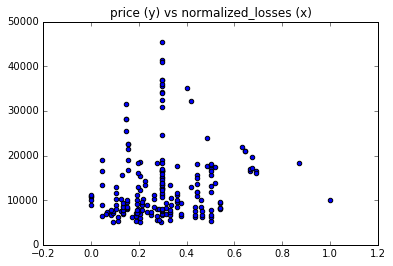

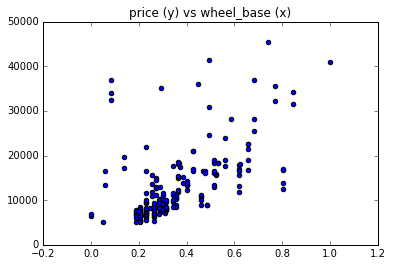

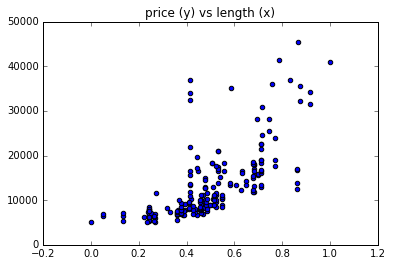

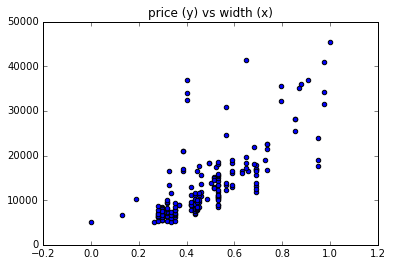

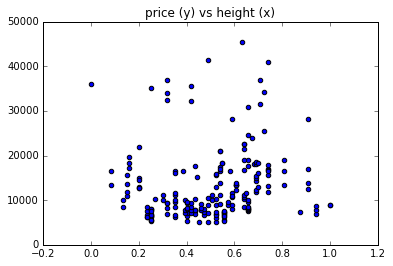

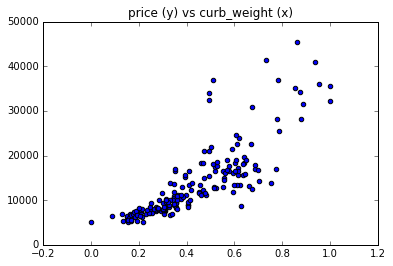

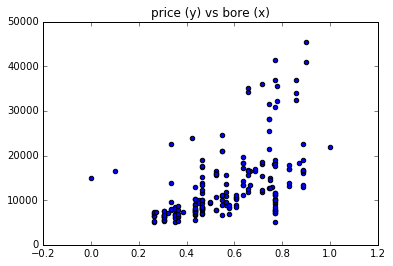

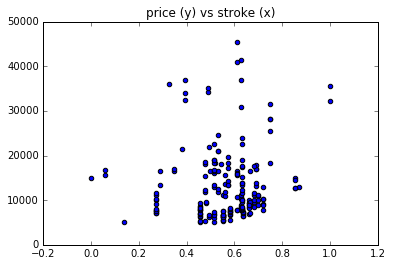

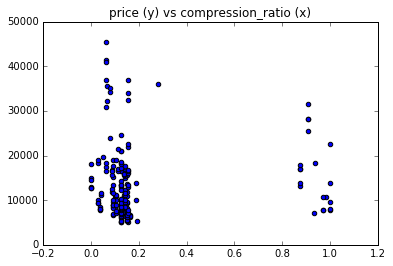

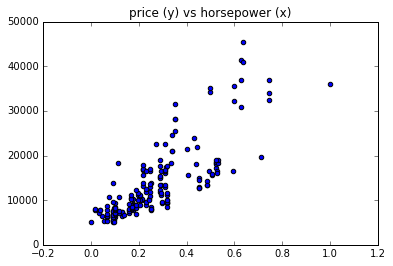

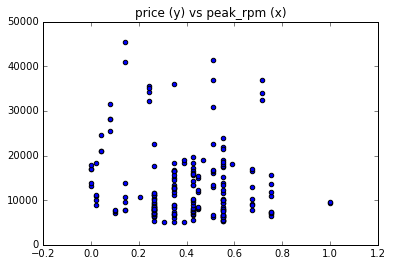

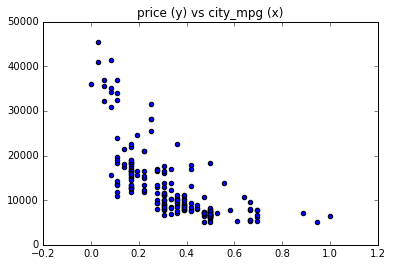

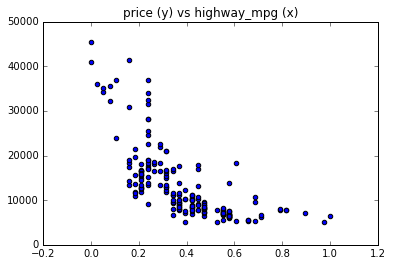

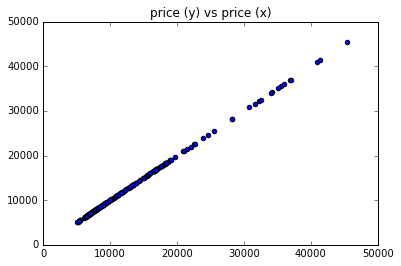

In [10]:
for col in numeric_cars.columns:
    plt.scatter(x = numeric_cars[col], y = numeric_cars["price"])
    plt.title("price (y) vs " + col + " (x)")
    plt.show()

<b>Columns with interesting corellations are: 
- length, width, curb_weight (positive)
- (wheel_base, bore, (positive))
- horsepower (positive)
- city_mpg, highway_mpg (negative)

## Now for some k-nearest testing:
- we want to predict the "price" column using different other columns
- to measure our accuracy, we will use the Root Mean Squared Error (RMSE)

In [17]:
def knn_train_test(df, train_col, test_col, k):
    # shuffle the dataframe:
    # np.random.seed(1)
    random_df = df.sample(frac = 1)
    
    #splitting the random df into training and test df
    last_train_idx = int((df.shape[0])/2)
    train_df = random_df.iloc[0:last_train_idx]
    test_df = random_df.iloc[last_train_idx:]
    
    #training and testing:
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(train_df[train_col], train_df[test_col])
    predictions = knn.predict(test_df[train_col])
    
    mse = mean_squared_error(test_df[test_col], predictions)
    rmse = mse ** 0.5
    
    return rmse

# this can be used to teest multiple times and take the average rmse value
def test_n_times(df, train_col, test_col, k, iterations):
    rmse_vals = []
    for i in range (0,iterations):
        rmse_vals.append(knn_train_test(numeric_cars, train_col, test_col, 5))
    mean = np.mean(rmse_vals)
    return mean


cols = numeric_cars.columns.drop("price") 
rmse_values = []

for col in cols:
    rmse = knn_train_test(numeric_cars, [col], "price", 5)
    rmse_values.append(rmse)

results = pd.Series(data = rmse_values, index = cols)
results = results.sort_values()
results
# these are the root mean squared error (rmse) results for testing one time with k = 5:

curb_weight          3947.090112
horsepower           4250.420720
width                4417.367421
length               4559.205700
city_mpg             5038.936229
highway_mpg          5207.219582
bore                 6175.003946
wheel_base           6271.852514
compression_ratio    6573.778137
peak_rpm             7297.885080
stroke               7564.242671
normalized_losses    7960.301294
height               9514.065841
dtype: float64

In [12]:
means = list()
for col in cols:
    mean = test_n_times(numeric_cars, [col], "price", 5, 200)
    means.append(mean)

results_ntimes = pd.Series(data = means, index = cols)
results_ntimes = results_ntimes.sort_values()
results_ntimes
# these are the resulting average rmses after performing 200 iterations with a k-value of 5 
# for all columns.
# this means that the training and test datasets were randomized 200 times and respective rmse
# values were calculated.

horsepower           4325.853781
curb_weight          4413.077914
highway_mpg          4599.485371
width                4699.434936
city_mpg             4735.259066
length               5643.297820
wheel_base           6185.593912
compression_ratio    6682.553982
bore                 6889.092756
stroke               7537.139534
normalized_losses    7757.596704
peak_rpm             7971.166081
height               7999.630164
dtype: float64

In [13]:
k_values = [1, 3, 5, 7, 9]

col_k_rmse = dict()

for col in cols:
    k_rmse = dict()
    for k in k_values:
        rmse = knn_train_test(numeric_cars, [col], "price", k)
        k_rmse[k] = rmse
    col_k_rmse[col] = k_rmse

col_k_rmse

{'bore': {1: 6615.9817487656355,
  3: 6098.5999159187713,
  5: 8044.4167198871537,
  7: 7651.0812957972139,
  9: 7135.8557518516709},
 'city_mpg': {1: 5124.4635650963501,
  3: 4380.5385900467636,
  5: 5199.1228300550856,
  7: 5662.6381948267008,
  9: 5813.8090257295453},
 'compression_ratio': {1: 8917.3878944453227,
  3: 7892.6097805337986,
  5: 6749.6114714552268,
  7: 6710.1555063947662,
  9: 5827.7094531107623},
 'curb_weight': {1: 5124.927317533391,
  3: 4637.2830827975122,
  5: 4917.6987634055022,
  7: 4110.0492257094811,
  9: 3759.9272181030447},
 'height': {1: 6287.8139603521986,
  3: 8003.6582575303228,
  5: 7681.8869660259907,
  7: 7285.1442061561002,
  9: 7894.0569077997061},
 'highway_mpg': {1: 5250.8448282157415,
  3: 4978.0469865199148,
  5: 3680.2240851339475,
  7: 4739.1466068291675,
  9: 5438.7831113536495},
 'horsepower': {1: 5379.1981065954433,
  3: 3458.6728435758259,
  5: 5054.0956374409861,
  7: 4765.0899744166118,
  9: 3816.1786897172219},
 'length': {1: 6301.0893

<b> plotting the rmse values for different k:

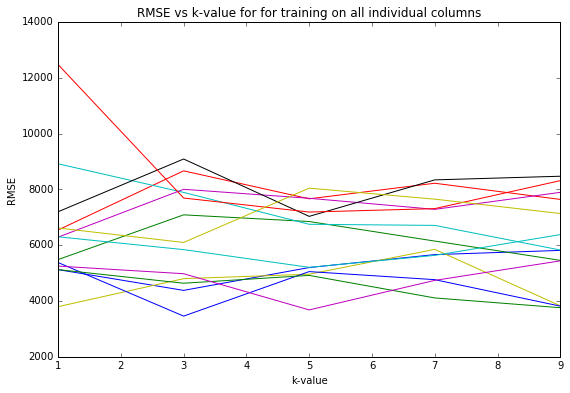

In [62]:
plt.figure(figsize = (9,6))
for key, value in col_k_rmse.items():
    x,y = zip(*sorted(value.items()))
    plt.plot(x,y)
plt.xlabel("k-value")
plt.ylabel("RMSE")
plt.title("RMSE vs k-value for for training on all individual columns")
plt.show()

In [15]:
# average rmse over 1000 iterations using all columns for training.

rmse_all_cols = test_n_times(numeric_cars, cols, "price", 5, 1000)
rmse_all_cols

4349.1544210620968

<b>using the j best features (horsepower & curb_weight): (j = 2,3,4,5)

In [27]:
rmse_best_two = test_n_times(numeric_cars, ["horsepower", "curb_weight"], "price", 5, 1000)
rmse_best_two

3565.7112927925605

In [30]:
rmse_best_three = test_n_times(numeric_cars, ["horsepower", "curb_weight", "highway_mpg"], "price", 5, 1000)
rmse_best_three

3738.6693887991805

In [32]:
rmse_best_four = test_n_times(numeric_cars, ["horsepower", "curb_weight", "highway_mpg", "width"], "price", 5, 1000)
rmse_best_four

3614.2563897660407

In [33]:
rmse_best_five = test_n_times(numeric_cars, ["horsepower", "curb_weight", "highway_mpg", "width", "city_mpg"], "price", 5, 1000)
rmse_best_five

3647.3784197714936

<b>Now lets vary the hyperparameters:

In [78]:
hyperparameters = range(1,26)

# modifying our base function:

def knn_test_hyp(df, train_col, test_col, hyperparameters):
    # shuffle the dataframe:
    #np.random.seed(1)
    random_df = df.sample(frac = 1)
    
    #splitting the random df into training and test df
    last_train_idx = int((df.shape[0])/2)
    train_df = random_df.iloc[0:last_train_idx]
    test_df = random_df.iloc[last_train_idx:]
    
    #training and testing:
    rmses = list()
    
    for k in hyperparameters:
        
        knn = KNeighborsRegressor(n_neighbors = k)
        knn.fit(train_df[train_col], train_df[test_col])
        predictions = knn.predict(test_df[train_col])
    
        mse = mean_squared_error(test_df[test_col], predictions)
        rmse = mse ** 0.5
        rmses.append(rmse)
        
    return rmses

best_two_rmses = knn_test_hyp(numeric_cars, ["horsepower", "curb_weight"], "price", hyperparameters)
best_four_rmses = knn_test_hyp(numeric_cars, ["horsepower", "curb_weight", "highway_mpg", "width"], "price", hyperparameters)
best_five_rmses = knn_test_hyp(numeric_cars, ["horsepower", "curb_weight", "highway_mpg", "width", "city_mpg"], "price", hyperparameters)

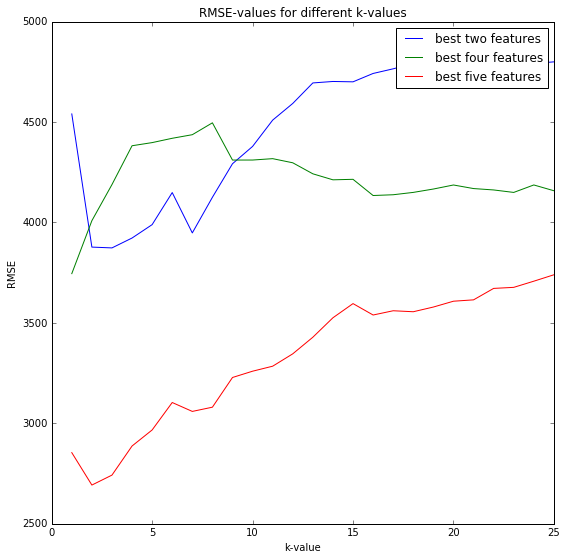

In [79]:
plt.figure(figsize = (9,9))
plt.plot(hyperparameters, best_two_rmses, label = "best two features")
plt.plot(hyperparameters, best_four_rmses, label = "best four features")
plt.plot(hyperparameters, best_five_rmses, label = "best five features")
plt.title("RMSE-values for different k-values")
plt.xlabel("k-value")
plt.legend()
plt.ylabel("RMSE")

plt.show()

<b>As seen above, only using one iteration gives pretty random measurements. We therefore customize
our function that iterates n times to return a list for given hyperparameters.

In [102]:
def knn_test_hyp_ntimes(df, train_col, test_col, hyperparameters, n):
    
    rmses_n = pd.Series([0 for i in range(len(hyperparameters))])
    for i in range(0,n):
        
        # shuffle the dataframe:
        #np.random.seed(1)
        random_df = df.sample(frac = 1)
    
        #splitting the random df into training and test df
        last_train_idx = int((df.shape[0])/2)
        train_df = random_df.iloc[0:last_train_idx]
        test_df = random_df.iloc[last_train_idx:]
    
        #training and testing:
        rmses = list()
    
        for k in hyperparameters:
        
            knn = KNeighborsRegressor(n_neighbors = k)
            knn.fit(train_df[train_col], train_df[test_col])
            predictions = knn.predict(test_df[train_col])
    
            mse = mean_squared_error(test_df[test_col], predictions)
            rmse = mse ** 0.5
            rmses.append(rmse)
        
        rmses_n = rmses_n + pd.Series(rmses)
    rmses_n = rmses_n/n
    return list(rmses_n)

best_two_ntimes = knn_test_hyp_ntimes(numeric_cars, ["horsepower", "curb_weight"], "price", range(1,26), 100)
best_four_ntimes = knn_test_hyp_ntimes(numeric_cars, ["horsepower", "curb_weight", "highway_mpg", "width"], "price", range(1,26), 100)
best_five_ntimes = knn_test_hyp_ntimes(numeric_cars, ["horsepower", "curb_weight", "highway_mpg", "width", "city_mpg"], "price", range(1,26), 100)

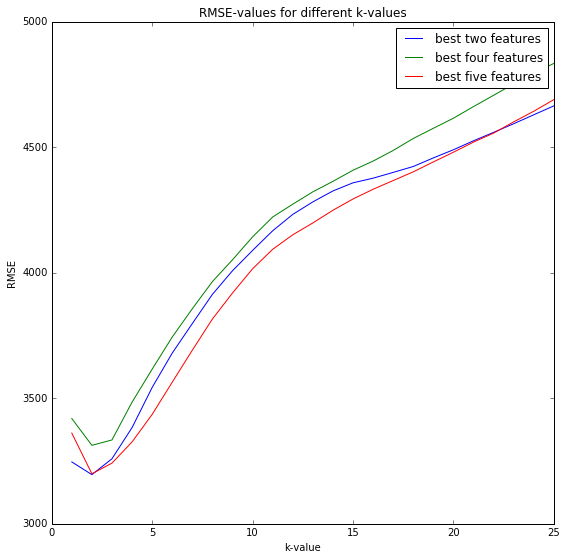

In [103]:
plt.figure(figsize = (9,9))
plt.plot(hyperparameters, best_two_ntimes, label = "best two features")
plt.plot(hyperparameters, best_four_ntimes, label = "best four features")
plt.plot(hyperparameters, best_five_ntimes, label = "best five features")
plt.title("RMSE-values for different k-values")
plt.xlabel("k-value")
plt.legend()
plt.ylabel("RMSE")

plt.show()

<b>Now we can see that for a k-value of 2 our algorithm produces the best results. Those are the results for 100 iterations, so the values are not totally accurate yet. Anyways, our advise would be to use a k-value of 2 to predict the prices of cars using our dataset.